In [56]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from smart_open import smart_open
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.cross_validation import train_test_split
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from nltk.corpus import stopwords
import os, codecs
%matplotlib inline
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from sklearn import metrics as skmetrics
# We'll hack a bit with the t-SNE code in sklearn 0.15.2.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
from sklearn.manifold import TSNE
from sklearn.utils.extmath import _ravel
# Random state.
RS = 20150101
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

## Model 1 evaluation

In [2]:
model = gensim.models.Word2Vec.load('/home/bahbbc/workspace/masters-big5/models/tweet50-600.model')
model.init_sims(replace=True)

2017-07-01 22:57:35,240 : INFO : loading Word2Vec object from /home/bahbbc/workspace/masters-big5/models/tweet50-600.model
2017-07-01 22:57:42,561 : INFO : loading wv recursively from /home/bahbbc/workspace/masters-big5/models/tweet50-600.model.wv.* with mmap=None
2017-07-01 22:57:42,562 : INFO : loading syn0 from /home/bahbbc/workspace/masters-big5/models/tweet50-600.model.wv.syn0.npy with mmap=None
2017-07-01 22:58:08,920 : INFO : setting ignored attribute syn0norm to None
2017-07-01 22:58:08,957 : INFO : loading syn1neg from /home/bahbbc/workspace/masters-big5/models/tweet50-600.model.syn1neg.npy with mmap=None
2017-07-01 22:59:21,719 : INFO : setting ignored attribute cum_table to None
2017-07-01 22:59:23,930 : INFO : loaded /home/bahbbc/workspace/masters-big5/models/tweet50-600.model
2017-07-01 23:00:54,845 : INFO : precomputing L2-norms of word weight vectors


In [3]:
num_features= 600

In [4]:
df = pd.read_csv('~/personality-normalized-word2vec-norm.csv', encoding='utf-8')
df.shape

(1039, 186)

In [5]:
train_w2v_data, test_w2v_data = train_test_split(df, test_size=0.3, random_state=42)

In [6]:
def predict(vectorizer, classifier, data):
    data_features = vectorizer.transform(data['formatted_text'])
    predictions = classifier.predict(data_features)
    target = data['extraversion_m']
    evaluate_prediction(predictions, target)

In [7]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    #print words.shape
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.wv.vocab:
            mean.append(wv.wv.syn0norm[wv.wv.vocab[word].index])
            all_words.add(wv.wv.vocab[word].index)
        #print mean

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(num_features,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, review) for review in text_list ])

In [8]:
def w2v_tokenize_text(text):
    tokens = []
    if text is np.nan:
        return []
    for sent in nltk.sent_tokenize(text, language='portuguese'):
        for word in nltk.word_tokenize(sent, language='portuguese'):
            if len(word) < 2:
                continue
            if word in stopwords.words('portuguese'):
                continue
            tokens.append(word)
    return tokens

In [65]:
test_tokenized = test_w2v_data.apply(lambda r: w2v_tokenize_text(r['formatted_text']), axis=1).values
train_tokenized = train_w2v_data.apply(lambda r: w2v_tokenize_text(r['formatted_text']), axis=1).values
all_data_tokenized = df.apply(lambda r: w2v_tokenize_text(r['formatted_text']), axis=1).values

In [66]:
%%time
X_train_word_average = word_averaging_list(model,train_tokenized)
X_test_word_average = word_averaging_list(model,test_tokenized)
all_data_average = word_averaging_list(model,all_data_tokenized)

2017-07-01 23:37:11,236 : WARNING : cannot compute similarity with no input []
2017-07-01 23:37:15,536 : WARNING : cannot compute similarity with no input []
2017-07-01 23:37:15,596 : WARNING : cannot compute similarity with no input []
2017-07-01 23:37:21,471 : WARNING : cannot compute similarity with no input []
2017-07-01 23:37:22,561 : WARNING : cannot compute similarity with no input []
2017-07-01 23:37:24,323 : WARNING : cannot compute similarity with no input []
2017-07-01 23:37:27,024 : WARNING : cannot compute similarity with no input []
2017-07-01 23:37:27,417 : WARNING : cannot compute similarity with no input []
2017-07-01 23:37:27,928 : WARNING : cannot compute similarity with no input []
2017-07-01 23:37:28,259 : WARNING : cannot compute similarity with no input []
2017-07-01 23:37:28,343 : WARNING : cannot compute similarity with no input []
2017-07-01 23:37:29,616 : WARNING : cannot compute similarity with no input []
2017-07-01 23:37:29,910 : WARNING : cannot compute s

CPU times: user 13 s, sys: 3.31 s, total: 16.3 s
Wall time: 41.9 s


In [17]:
del model

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.externals import joblib

force = False
model_trainer = RandomizedSearchCV(
    n_iter=1, 
    estimator=DecisionTreeRegressor(),
    param_distributions={
        "max_features": ["log2"],
        "random_state": [42],
        "criterion":['mse']
    },
    verbose=True,
    refit=True,
    cv=10,
    n_jobs=-1
)

In [125]:
def scatter(x, colors, rrange):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in rrange:
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=3, foreground="w"),
            PathEffects.Normal()
            ])
        txts.append(txt)

    return f, ax, sc, txts

In [126]:
extraversion = df.extraversion.astype('int')

In [127]:
X = np.vstack([all_data_average[extraversion==i]
               for i in range(1,6)])
y = np.hstack([df.extraversion.astype('int')[extraversion==i]
               for i in range(1,6)])

In [137]:
Xx = np.vstack([all_data_average[df.extraversion_m==i]
               for i in range(0,2)])
yy = np.hstack([df.extraversion_m[df.extraversion_m==i]
               for i in range(0,2)])

In [129]:
five_class = TSNE(random_state=RS).fit_transform(X)

In [138]:
dual_class = TSNE(random_state=RS).fit_transform(Xx)

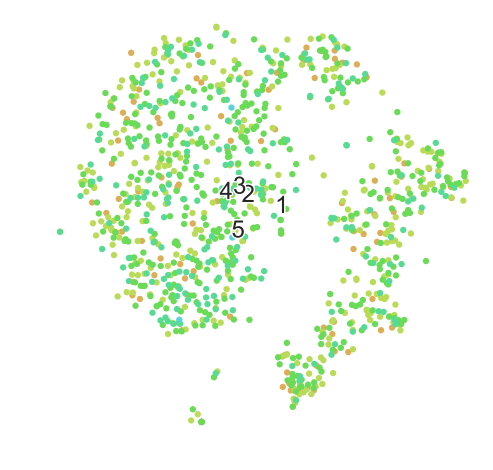

In [131]:
scatter(five_class, y, range(1,6))
plt.savefig('digits_tsne-generated.png', dpi=120)

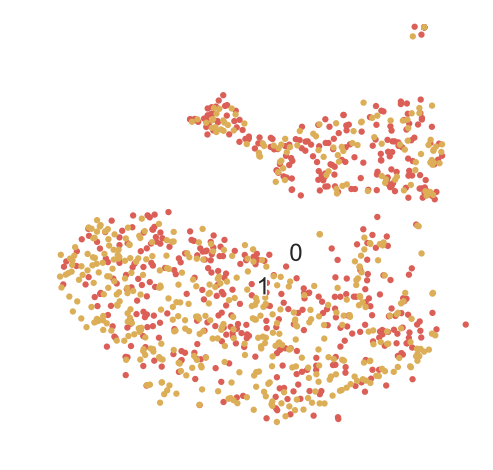

In [140]:
scatter(dual_class, yy, range(0,2))
plt.savefig('digits_tsne-generated.png', dpi=120)

In [23]:
np.hstack(train_w2v_data.extraversion)

array([ 3.25,  1.88,  2.63,  3.63,  2.13,  2.75,  3.75,  3.  ,  3.5 ,
        3.  ,  2.  ,  3.75,  3.  ,  2.38,  3.88,  3.25,  4.25,  3.88,
        3.75,  3.25,  3.63,  2.5 ,  4.25,  2.38,  3.63,  2.88,  3.5 ,
        3.  ,  3.75,  3.25,  4.  ,  4.75,  3.5 ,  2.25,  4.13,  4.25,
        2.63,  2.25,  4.13,  1.5 ,  2.88,  1.88,  1.5 ,  3.5 ,  3.38,
        3.63,  3.5 ,  2.75,  1.88,  3.75,  4.  ,  2.88,  2.88,  2.25,
        2.75,  2.  ,  4.13,  5.  ,  2.75,  3.38,  4.13,  4.13,  3.5 ,
        2.13,  3.38,  3.88,  4.  ,  3.  ,  4.  ,  3.63,  1.38,  3.75,
        3.13,  2.25,  4.38,  1.88,  2.88,  3.63,  3.13,  4.25,  2.88,
        3.88,  2.25,  3.38,  3.5 ,  2.38,  3.88,  3.38,  3.13,  2.25,
        2.25,  4.88,  4.5 ,  2.38,  3.75,  3.63,  4.5 ,  2.13,  2.25,
        3.13,  3.75,  3.5 ,  2.5 ,  1.88,  2.88,  2.13,  2.88,  1.88,
        2.88,  3.25,  2.38,  2.38,  1.75,  3.75,  3.13,  3.38,  1.75,
        3.5 ,  3.38,  3.63,  2.88,  2.63,  3.25,  3.  ,  3.  ,  4.13,
        3.5 ,  3.38,

## Extraversion evaluation

In [19]:
df.extraversion_m.value_counts()

0    529
1    510
Name: extraversion_m, dtype: int64

In [20]:
%%time
model_trainer.fit(X_train_word_average, train_w2v_data['extraversion_m'])
model = model_trainer.best_estimator_

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


CPU times: user 294 ms, sys: 369 ms, total: 663 ms
Wall time: 3.11 s


In [21]:
yp = model.predict(X_test_word_average)
yt = test_w2v_data['extraversion_m']

In [22]:
pd.DataFrame(
    index=pd.Index([0, 1], name="y_true"),
    columns=pd.Index([0, 1], name="y_pred"),
    data=skmetrics.confusion_matrix(y_true=yt, y_pred=yp)
)

ValueError: Can't handle mix of binary and continuous

In [ ]:
print skmetrics.classification_report(y_true=yt, y_pred=yp)

In [ ]:
accuracy_score(yt, yp)

In [ ]:
print '--------- TRAIN -----------------'

In [ ]:
ytp = model.predict(X_train_word_average)
ytt = train_w2v_data['extraversion_m']

In [ ]:
print skmetrics.classification_report(y_true=ytt, y_pred=ytp)

In [ ]:
print accuracy_score(ytt, ytp)

## Agreableness evaluation

In [ ]:
%%time
model_trainer.fit(X_train_word_average, train_w2v_data['agreeableness'])
model = model_trainer.best_estimator_

In [ ]:
yp = model.predict(X_test_word_average)
yt = test_w2v_data['agreeableness']

In [ ]:
skmetrics.mean_squared_error(yt, yp)

In [ ]:
skmetrics.r2_score(yt, yp)

In [ ]:
scipy.stats.pearsonr(yt,yp)

## Conscientiousness evaluation

In [ ]:
%%time
model_trainer.fit(X_train_word_average, train_w2v_data['conscientiousness'])
model = model_trainer.best_estimator_

In [ ]:
yp = model.predict(X_test_word_average)
yt = test_w2v_data['conscientiousness']

In [ ]:
skmetrics.mean_squared_error(yt, yp)

In [ ]:
skmetrics.r2_score(yt, yp)

In [ ]:
scipy.stats.pearsonr(yt,yp)

## Neuroticism evaluation

In [ ]:
%%time
model_trainer.fit(X_train_word_average, train_w2v_data['neuroticism'])
model = model_trainer.best_estimator_

In [ ]:
yp = model.predict(X_test_word_average)
yt = test_w2v_data['neuroticism']

In [ ]:
skmetrics.mean_squared_error(yt, yp)

In [ ]:
skmetrics.r2_score(yt, yp)

In [ ]:
scipy.stats.pearsonr(yt,yp)

## Openess evaluation

In [ ]:
%%time
model_trainer.fit(X_train_word_average, train_w2v_data['openness'])
model = model_trainer.best_estimator_

In [ ]:
yp = model.predict(X_test_word_average)
yt = test_w2v_data['openness']

In [ ]:
skmetrics.mean_squared_error(yt, yp)

In [ ]:
skmetrics.r2_score(yt, yp)

In [ ]:
scipy.stats.pearsonr(yt,yp)